In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone, timedelta

In [203]:
# loading files
file1_locations = 'Jan20 Rail Stops and Geocoded Locations.txt'
file2_data = 'Light Rail and Commuter Rail Data Dec 1 2018 to Nov 2019.txt'

In [204]:
locations = pd.read_csv(file1_locations,
                       header=0,
                       sep=';')
locations.head(10)
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 4 columns):
STOPABBR     154 non-null int64
STOPNAME     154 non-null object
LATITUDE     154 non-null float64
LONGITUDE    154 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 4.9+ KB


In [205]:
trains = pd.read_csv(file2_data,
                       header=0,
                       sep=';')

In [206]:
trains.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1838225 entries, 0 to 1838224
Data columns (total 47 columns):
SERIAL_NUMBER            int64
SCHEDULE_NAME            object
SIGNUP_NAME              object
SURVEY_SOURCE            int64
PATTERN_ID               int64
BRANCH                   object
ROUTE_NUMBER             int64
ROUTE_NAME               object
DIRECTION_NAME           object
SERVICE_TYPE             object
SERVICE_MODE             object
SURVEY_DATE_EFFECTIVE    object
SURVEY_DATE_ATYPICAL     int64
TIME_PERIOD              object
SERVICE_DAY              int64
SERVICE_PERIOD           object
TRIP_KEY                 int64
BLOCK_NUMBER             int64
VEHICLE_NUMBER           float64
GARAGE_NAME              object
DIVISION_NAME            object
SORT_ORDER               int64
STOP_ID                  int64
MAIN_CROSS_STREET        object
TIMEPOINT                int64
CITY                     object
COUNTY                   object
TIME_SCHEDULED           object
T

# not all STOP IDs in trains has a corresponding STOPNAME in locations lookup. missing stopnames will be replaced with corresponding CROSS_STREET_NAMES where necessary. 

In [207]:
# Create a merged copy of trains that brings in stop information (specifically STOPNAME) from locations. Some STOP_IDs will
# not have corresponding STOPNAMES 
train_df = pd.merge(trains, 
           locations,
           how = 'left',
           left_on = 'STOP_ID',
           right_on = 'STOPABBR')

In [208]:
train_df.head(2)

,SERIAL_NUMBER,SCHEDULE_NAME,SIGNUP_NAME,SURVEY_SOURCE,PATTERN_ID,BRANCH,ROUTE_NUMBER,ROUTE_NAME,DIRECTION_NAME,SERVICE_TYPE,...,SL_COUNT,EARLY,ON_TIME,LATE,ON_DETOUR,RECORD_ID,STOPABBR,STOPNAME,LATITUDE,LONGITUDE
0,34889599,Aug18 (Friday),Aug18,3,1080310,A,111,111: Commuter Rail A Line,W-Bound,Commuter Rail,...,0,0,1,0,False,61848232,NaN,NaN,NaN,NaN
1,34889599,Aug18 (Friday),Aug18,3,1080310,A,111,111: Commuter Rail A Line,W-Bound,Commuter Rail,...,0,0,1,0,False,61848233,NaN,NaN,NaN,NaN


In [209]:
train_df[train_df.STOPNAME.isnull()]['STOP_ID'].unique()

array([34476, 34606, 34474, 34472, 34470, 34468, 34667, 34465, 34467,
       34469, 34471, 34473, 34466, 34605, 34475], dtype=int64)

In [210]:
# Create dataframes of each unique listing of STOP IDs and STOPABBR across trains and locations, respectively
train_STOP_IDs = trains['STOP_ID'].unique()
locations_STOPABBRs = locations['STOPABBR'].unique()
train_STOP_IDs = pd.Series(train_STOP_IDs).to_frame()
locations_STOPABBRs = pd.Series(locations_STOPABBRs).to_frame()

In [211]:
# Use an outer merge with an indicator mark the origin of each unique STOP ID / STOPABBR
stops_comp = train_STOP_IDs.merge(locations_STOPABBRs, 
                     indicator = True,
                     how = 'outer')

In [212]:
# Create a list of STOP_IDs that are exclusive to the original train data that is missing in the locations lookup data
missing_stopnames = stops_comp[stops_comp._merge == 'left_only'][0].tolist()

In [213]:
# fill STOPNAMES marked with NA using corresponding MAIN CROSS STREET
train_df.STOPNAME.fillna(train_df.MAIN_CROSS_STREET, inplace=True)

# removal of unnecessary fields

In [214]:
train_df = train_df.drop(['ON_DETOUR','SL_COUNT','SM_COUNT','AVL_COUNT','SL_AVAILABLE','SM_AVAILABLE','AVL_AVAILABLE','APC_AVAILABLE'], axis=1)

In [134]:
train_df.columns

Index(['SERIAL_NUMBER', 'SCHEDULE_NAME', 'SIGNUP_NAME', 'SURVEY_SOURCE',
       'PATTERN_ID', 'BRANCH', 'ROUTE_NUMBER', 'ROUTE_NAME', 'DIRECTION_NAME',
       'SERVICE_TYPE', 'SERVICE_MODE', 'SURVEY_DATE_EFFECTIVE',
       'SURVEY_DATE_ATYPICAL', 'TIME_PERIOD', 'SERVICE_DAY', 'SERVICE_PERIOD',
       'TRIP_KEY', 'BLOCK_NUMBER', 'VEHICLE_NUMBER', 'GARAGE_NAME',
       'DIVISION_NAME', 'SORT_ORDER', 'STOP_ID', 'MAIN_CROSS_STREET',
       'TIMEPOINT', 'CITY', 'COUNTY', 'TIME_SCHEDULED', 'TIME_ACTUAL_ARRIVE',
       'TIME_ACTUAL_DEPART', 'DWELL_TIME', 'TRIP_DIFF_MINUTES', 'FREE_RUNNING',
       'EVENT_COUNT', 'APC_COUNT', 'EARLY', 'ON_TIME', 'LATE', 'RECORD_ID',
       'STOPABBR', 'STOPNAME', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

# updating datetime and time-based fields (TIME_ACTUAL_ARRIVE, TIME_ACTUAL_DEPART)

In [215]:
# convert TIME_ACTUAL_DEPART, TIME_ACTUAL_ARRIVE, TIME_SCHEDULED to datetime objects
train_df['TIME_ACTUAL_DEPART'] = pd.to_datetime(train_df.TIME_ACTUAL_DEPART)
train_df['TIME_ACTUAL_ARRIVE'] = pd.to_datetime(train_df.TIME_ACTUAL_ARRIVE)
train_df['TIME_SCHEDULED'] = pd.to_datetime(train_df.TIME_SCHEDULED)

In [235]:
train_df[['TIME_ACTUAL_DEPART','TIME_ACTUAL_ARRIVE','ARRIVAL_TIME','DEPART_TIME']].iloc[1834856]

TIME_ACTUAL_DEPART    1899-12-30 00:00:35
TIME_ACTUAL_ARRIVE    1899-12-30 00:00:14
ARRIVAL_TIME                     00:00:14
DEPART_TIME                      00:00:35
Name: 1834856, dtype: object

In [216]:
# capture date of SCHEDULED_DAY and times from ARRIVAL_TIME and DEPART_TIME
train_df['SCHEDULED_DAY'] = pd.to_datetime(train_df.TIME_SCHEDULED.dt.date)
train_df['ARRIVAL_TIME'] = [datetime.time(d) for d in train_df.TIME_ACTUAL_ARRIVE]
train_df['DEPART_TIME'] = [datetime.time(d) for d in train_df.TIME_ACTUAL_DEPART]

In [251]:
# create 2 new datetime fields for actual ARRIVAL and actual DEPARTURE
train_df['ARRIVAL'] = pd.to_datetime(train_df['SCHEDULED_DAY'].dt.strftime('%Y-%m-%d') + ' ' + train_df['ARRIVAL_TIME'].astype(str))
train_df['DEPARTURE'] = pd.to_datetime(train_df['SCHEDULED_DAY'].dt.strftime('%Y-%m-%d') + ' ' + train_df['DEPART_TIME'].astype(str))

# Create a new field to evaluate if departure dates should be adjusted for trains departing around midnight 
train_df['DEP_ADJUSTER'] = (train_df['TIME_SCHEDULED'] - train_df['DEPARTURE'])
train_df['DEP_ADJUSTER'] = train_df['DEP_ADJUSTER']/np.timedelta64(1,'s')
# Create a new field to evaluate if days of arrival should be adjusted for trains arriving around midnight 
train_df['ARR_ADJUSTER'] = (train_df['TIME_SCHEDULED'] - train_df['ARRIVAL'])
train_df['ARR_ADJUSTER'] = train_df['ARR_ADJUSTER']/np.timedelta64(1,'s')



# Adjust departure date forward or backward by a day based on gap betweeen scheduled departure and actual departure
#train_df.loc[train_df['DEP_ADJUSTER'] > 43200, 'DEPARTURE'] = trains_games['DEPARTURE'].apply(lambda x: x + pd.DateOffset(days=1))
#train_df.loc[train_df['DEP_ADJUSTER'] < -43200, 'DEPARTURE'] = trains_games['DEPARTURE'].apply(lambda x: x - pd.DateOffset(days=1))

# Adjust arrival date forward or backward by a day based on gap betweeen scheduled departure and actual arrival
#train_df.loc[train_df['ARR_ADJUSTER'] > 43200, 'ARRIVAL'] = trains_games['ARRIVAL'].apply(lambda x: x + pd.DateOffset(days=1))
#train_df.loc[train_df['ARR_ADJUSTER'] < -43200, 'ARRIVAL'] = trains_games['ARRIVAL'].apply(lambda x: x - pd.DateOffset(days=1))
    

In [252]:
train_df.loc[train_df['DEP_ADJUSTER'] > 43200, 'NEW_DEPARTURE'] = trains_games['DEPARTURE'].apply(lambda x: x + timedelta(days=1))
train_df[['DEP_ADJUSTER',
          'ARR_ADJUSTER',
          'SCHEDULED_DAY',
          'TIME_SCHEDULED',
          'TIME_ACTUAL_DEPART',
          'DEPARTURE',
          'NEW_DEPARTURE',
          'TIME_ACTUAL_ARRIVE',
          'ARRIVAL',
          'TRIP_DIFF_MINUTES']].iloc[1834856]

DEP_ADJUSTER                        86305
ARR_ADJUSTER                        86326
SCHEDULED_DAY         2019-11-30 00:00:00
TIME_SCHEDULED        2019-11-30 23:59:00
TIME_ACTUAL_DEPART    1899-12-30 00:00:35
DEPARTURE             2019-11-30 00:00:35
NEW_DEPARTURE         2019-11-28 13:21:22
TIME_ACTUAL_ARRIVE    1899-12-30 00:00:14
ARRIVAL               2019-11-30 00:00:14
TRIP_DIFF_MINUTES                   -1.58
Name: 1834856, dtype: object

In [232]:
train_df[['DEP_ADJUSTER',
          'ARR_ADJUSTER',
          'SCHEDULED_DAY',
          'TIME_SCHEDULED',
          'TIME_ACTUAL_DEPART',
          'DEPARTURE',
          'TIME_ACTUAL_ARRIVE',
          'ARRIVAL',
          'TRIP_DIFF_MINUTES'
          ]][train_df.DEP_ADJUSTER > 43200]

,DEP_ADJUSTER,ARR_ADJUSTER,SCHEDULED_DAY,TIME_SCHEDULED,TIME_ACTUAL_DEPART,DEPARTURE,TIME_ACTUAL_ARRIVE,ARRIVAL,TRIP_DIFF_MINUTES
758,86238.0,86257.0,2018-12-01,2018-12-01 23:58:30,1899-12-30 00:01:12,2018-12-03 00:01:12,1899-12-30 00:00:53,2018-12-03 00:00:53,-2.70
23008,86294.0,86312.0,2018-12-07,2018-12-07 23:59:30,1899-12-30 00:01:16,2018-12-09 00:01:16,1899-12-30 00:00:58,2018-12-09 00:00:58,-1.77
24448,86252.0,86274.0,2018-12-07,2018-12-07 23:59:00,1899-12-30 00:01:28,2018-12-09 00:01:28,1899-12-30 00:01:06,2018-12-09 00:01:06,-2.47
29807,86268.0,86268.0,2018-12-09,2018-12-09 23:58:45,1899-12-30 00:00:57,2018-12-11 00:00:57,1899-12-30 00:00:57,2018-12-11 00:00:57,-2.20
38695,86042.0,-176.0,2018-12-11,2018-12-11 23:55:30,1899-12-30 00:01:28,2018-12-13 00:01:28,1899-12-30 23:58:26,2018-12-11 23:58:26,-2.93
...,...,...,...,...,...,...,...,...,...
1832751,86082.0,86153.0,2019-11-27,2019-11-27 23:57:45,1899-12-30 00:03:03,2019-11-28 10:34:31,1899-12-30 00:01:52,2019-11-28 10:34:31,-5.30
1833776,86178.0,86218.0,2019-11-30,2019-11-30 23:57:00,1899-12-30 00:00:42,2019-11-28 05:17:43,1899-12-30 00:00:02,2019-11-28 05:16:51,-3.70
1833777,86178.0,86218.0,2019-11-30,2019-11-30 23:57:00,1899-12-30 00:00:42,2019-11-28 05:21:38,1899-12-30 00:00:02,2019-11-28 05:21:19,-3.70
1834856,86305.0,86326.0,2019-11-30,2019-11-30 23:59:00,1899-12-30 00:00:35,2019-11-28 13:21:22,1899-12-30 00:00:14,2019-11-28 13:20:57,-1.58


In [139]:
train_df = train_df.drop(['TIME_ACTUAL_DEPART','TIME_ACTUAL_ARRIVE','ARR_ADJUSTER','DEP_ADJUSTER'], axis=1)

In [140]:
train_df['TIME_TO_SCH_DEPART'] = (train_df['TIME_SCHEDULED'] - train_df['ARRIVAL'])
train_df['TIME_TO_SCH_DEPART'] = train_df['TIME_TO_SCH_DEPART']/np.timedelta64(1,'s')

# Completing county lookups where null

In [141]:
# Create new county lookup field
train_df['LOOKUP_COUNTY'] = train_df['COUNTY']

In [142]:
# Set stations in Douglas county to Arapahoe County for weather lookup. Douglas County is not available in weather data
# Note that Sky Ridge Station, Lone Tree City Center Station, and Ridgegate Parkway Station are in Douglas County 
# despite having originally null values.
train_df.loc[train_df.COUNTY == 'Douglas','LOOKUP_COUNTY'] = 'Arapahoe'

In [143]:
missing_counties = train_df[train_df.LOOKUP_COUNTY.isnull()]['STOPNAME'].unique() 

In [144]:
# Output the file to a csv to record the county for each station while researching
pd.DataFrame(missing_counties).to_csv('missing_counties.csv',header=True,index=None)

In [145]:
# Create datafataframe from researched station-county list for those originally missing counties
missing_counties_list = 'missing_counties_researched.csv'
county_updates = pd.read_csv(missing_counties_list,
                       header=0,
                       sep=',')
county_updates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 2 columns):
Station    40 non-null object
County     40 non-null object
dtypes: object(2)
memory usage: 768.0+ bytes


In [146]:
# Merge the county lookup to fill the missing counties
train_df = pd.merge(train_df,
                    county_updates,
                   how='left',
                   left_on = 'STOPNAME',
                   right_on = 'Station')

In [147]:
# Fill the missing LOOKUP_COUNTY with the new County value
train_df.loc[train_df.LOOKUP_COUNTY.isnull(),'LOOKUP_COUNTY'] = train_df['County']

In [148]:
# Drop the 2 recently merged columns
train_df = train_df.drop(['Station','County'],axis=1)

In [149]:
train_df['LOOKUP_COUNTY'].unique()

array(['Denver', 'Adams', 'Arapahoe', 'Jefferson'], dtype=object)

# Data Wrangling for Rockies data

In [150]:
rockies_file = 'rockies.xlsx'
rockies_games = pd.read_excel(rockies_file, 
                              sheet_name = 'sports_ref',
                             usecols = [1,4,5,16,17]
                             ,names = ['Date','At','Opp','Duration','Day/Night'])
rockies_times = pd.read_excel(rockies_file, 
                              sheet_name = 'DP',
                             usecols = [0,1,2])

In [151]:
# Set Date columns to datetime objects
rockies_times['Date'] = pd.to_datetime(rockies_times['Date'], errors='coerce')
rockies_games['Date'] = pd.to_datetime(rockies_games['Date'],errors = 'coerce')


In [152]:
# View NA dates in games files and fill them out according to double headers held on July 15th and 24th
rockies_games.loc[rockies_games.Date.isnull()]
rockies_games[91:103]
rockies_games.iloc[92:94,0] = pd.to_datetime('2019-07-15')
rockies_games.iloc[100:102,0] = pd.to_datetime('2019-07-24')

In [153]:
# Removal of away games
rockies_games.head(10)
away_indc = rockies_games[rockies_games.At == '@'].index
rockies_games.drop(away_indc, inplace=True)
rockies_games.head(5)

,Date,At,Opp,Duration,Day/Night
7,2019-04-05,NaN,LAD,03:52:00,D
8,2019-04-06,NaN,LAD,03:19:00,N
9,2019-04-07,NaN,LAD,03:52:00,N
10,2019-04-08,NaN,ATL,02:59:00,N
11,2019-04-09,NaN,ATL,03:12:00,N


In [154]:
# Removal of away games and all star break
away_indc_times = rockies_times[rockies_times.Opponent.str.startswith('at')].index
rockies_times.drop(away_indc_times, inplace=True)
all_star_game = rockies_times[rockies_times.Opponent == 'All-Star Break'].index
rockies_times.drop(all_star_game, inplace=True)

In [155]:
# Reset indeces
rockies_games.reset_index(drop=True, inplace=True)
rockies_times.reset_index(drop=True, inplace=True)

In [156]:
Abbr_Lookup = list(rockies_games.Opp.unique())
Abbr_Def = list(rockies_times.Opponent.unique())
len(Abbr_Lookup)
len(Abbr_Def)

18

In [157]:
MLB_team_dict = dict(zip(Abbr_Def, Abbr_Lookup))
print(MLB_team_dict)

{'Los Angeles Dodgers': 'LAD', 'Atlanta Braves': 'ATL', 'Philadelphia Phillies': 'PHI', 'Washington Nationals': 'WSN', 'Arizona Diamondbacks': 'ARI', 'San Francisco Giants': 'SFG', 'San Diego Padres': 'SDP', 'Baltimore Orioles': 'BAL', 'Toronto Blue Jays': 'TOR', 'Chicago Cubs': 'CHC', 'Houston Astros': 'HOU', 'Cincinnati Reds': 'CIN', 'Miami Marlins': 'MIA', 'Boston Red Sox': 'BOS', 'Pittsburgh Pirates': 'PIT', 'St. Louis Cardinals': 'STL', 'New York Mets': 'NYM', 'Milwaukee Brewers': 'MIL'}


In [158]:
rockies_times['Opp_Cd'] = rockies_times['Opponent'].map(MLB_team_dict)

In [159]:
rockies_times.rename(columns = {'Date':'Sch_Date'}, inplace = True)
rockies = pd.merge(rockies_games,
                  rockies_times,
                  how = 'left',
                  left_on = ['Date','Opp'],
                  right_on = ['Sch_Date','Opp_Cd'],
                  suffixes = ('_act','_sch'))

In [160]:
# Validation of dataframe with merged actual day and scheduled time. Valdate opponents and date scheduled and occurred
# Game on May 8th was cancelled and added in as a double-header on July 15th. The Double-Header began at 12:10PM.
rockies.groupby('Date').size().sort_values(ascending=False)

# Confirm cancelled game on May 8th does not appear
rockies.loc[rockies.Date.dt.month == 5]

# Reassign 12:10 to 1st of Double-Header on July 15th
rockies.at[46,'Time'] = '12:10 p.m.'

In [161]:
# updating re-scheduled final ATL series closer on August 26th that started at 3:10pm
rockies.at[62,'Time'] = '3:10 p.m.'

# Data Wrangling for Broncos

In [162]:
broncos_file = 'broncos.xlsx'
broncos_games_18 = pd.read_excel(broncos_file
                             ,skiprows = 1
                             ,header = 0
                             ,parse_dates = True,
                             date_parser = True,
                             sheet_name = '2018',
                             usecols = [0,2,3,5,6,8,9],
                             names = ['Week','Date', 'Time','Result','OT','At','Opp'])
broncos_games_19 = pd.read_excel(broncos_file
                             ,skiprows = 1
                             ,header = 0
                             ,parse_dates = True,
                             date_parser = True,
                             sheet_name = '2018',
                             usecols = [0,2,3,5,6,8,9],
                             names = ['Week','Date', 'Time','Result','OT','At','Opp'])
broncos_games_19.head(10)

,Week,Date,Time,Result,OT,At,Opp
0,1,2018-09-09,4:25PM ET,W,NaN,NaN,Seattle Seahawks
1,2,2018-09-16,4:25PM ET,W,NaN,NaN,Oakland Raiders
2,3,2018-09-23,1:00PM ET,L,NaN,@,Baltimore Ravens
3,4,2018-10-01,8:15PM ET,L,NaN,NaN,Kansas City Chiefs
4,5,2018-10-07,1:00PM ET,L,NaN,@,New York Jets
5,6,2018-10-14,4:05PM ET,L,NaN,NaN,Los Angeles Rams
6,7,2018-10-18,8:20PM ET,W,NaN,@,Arizona Cardinals
7,8,2018-10-28,1:00PM ET,L,NaN,@,Kansas City Chiefs
8,9,2018-11-04,4:05PM ET,L,NaN,NaN,Houston Texans
9,10,NaT,NaN,NaN,NaN,NaN,Bye Week


In [163]:
broncos_games_18.info()
broncos_games_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 7 columns):
Week      17 non-null int64
Date      16 non-null datetime64[ns]
Time      16 non-null object
Result    16 non-null object
OT        0 non-null float64
At        8 non-null object
Opp       17 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 7 columns):
Week      17 non-null int64
Date      16 non-null datetime64[ns]
Time      16 non-null object
Result    16 non-null object
OT        0 non-null float64
At        8 non-null object
Opp       17 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.1+ KB


In [164]:
broncos = broncos_games_18.append(broncos_games_19, ignore_index=True)
print(broncos.head(10))
print(broncos.tail(10))

   Week       Date       Time Result  OT   At                 Opp
0     1 2018-09-09  4:25PM ET      W NaN  NaN    Seattle Seahawks
1     2 2018-09-16  4:25PM ET      W NaN  NaN     Oakland Raiders
2     3 2018-09-23  1:00PM ET      L NaN    @    Baltimore Ravens
3     4 2018-10-01  8:15PM ET      L NaN  NaN  Kansas City Chiefs
4     5 2018-10-07  1:00PM ET      L NaN    @       New York Jets
5     6 2018-10-14  4:05PM ET      L NaN  NaN    Los Angeles Rams
6     7 2018-10-18  8:20PM ET      W NaN    @   Arizona Cardinals
7     8 2018-10-28  1:00PM ET      L NaN    @  Kansas City Chiefs
8     9 2018-11-04  4:05PM ET      L NaN  NaN      Houston Texans
9    10        NaT        NaN    NaN NaN  NaN            Bye Week
    Week       Date       Time Result  OT   At                   Opp
24     8 2018-10-28  1:00PM ET      L NaN    @    Kansas City Chiefs
25     9 2018-11-04  4:05PM ET      L NaN  NaN        Houston Texans
26    10        NaT        NaN    NaN NaN  NaN              Bye Wee

In [165]:
# Drop Bye Week rows and away games
broncos.dropna(thresh=5,inplace=True)

broncos = broncos.loc[broncos.At.isnull()]
broncos.reset_index(inplace=True,
                   drop=True)

# Data Wrangling for Nuggets

In [166]:
nuggets_sheets = pd.ExcelFile('nuggets.xlsx')
nuggets_sheets.sheet_names

['2019_2020', '2018_2019']

In [167]:
nuggets_file = 'nuggets.xlsx'
nuggets_games_18_19 = pd.read_excel(nuggets_file,
                             header = 0,
                             parse_dates = True,
                             date_parser = True,
                             sheet_name = '2018_2019',
                             usecols = [0,1,2,5,6,8],
                             names = ['G','Date', 'Time','At','Opponent','OT']
                                   )
nuggets_games_19_20 = pd.read_excel(nuggets_file,
                             header = 0,
                             parse_dates = True,
                             date_parser = True,
                             sheet_name = '2019_2020',
                             usecols = [0,1,2,5,6,8],
                             names = ['G','Date', 'Time','At','Opponent','OT']
                                   )
#nuggets_games_18_19.head(10)
nuggets_games_18_19['Date'] = pd.to_datetime(nuggets_games_18_19['Date'], errors='coerce')
nuggets_games_19_20['Date'] = pd.to_datetime(nuggets_games_19_20['Date'], errors='coerce')
print(nuggets_games_19_20.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 6 columns):
G           82 non-null int64
Date        82 non-null datetime64[ns]
Time        82 non-null object
At          41 non-null object
Opponent    82 non-null object
OT          3 non-null object
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 4.0+ KB
None


In [168]:
nuggets_games_18_19.head(10)

,G,Date,Time,At,Opponent,OT
0,1,2018-10-17,10:30p,@,Los Angeles Clippers,NaN
1,2,2018-10-20,9:00p,NaN,Phoenix Suns,NaN
2,3,2018-10-21,8:00p,NaN,Golden State Warriors,NaN
3,4,2018-10-23,9:00p,NaN,Sacramento Kings,NaN
4,5,2018-10-25,10:30p,@,Los Angeles Lakers,NaN
5,6,2018-10-29,9:00p,NaN,New Orleans Pelicans,NaN
6,7,2018-10-31,8:00p,@,Chicago Bulls,OT
7,8,2018-11-01,7:00p,@,Cleveland Cavaliers,NaN
8,9,2018-11-03,9:00p,NaN,Utah Jazz,NaN
9,10,2018-11-05,9:00p,NaN,Boston Celtics,NaN


In [169]:
nuggets = nuggets_games_18_19.append(nuggets_games_19_20,
                          ignore_index=True)
nuggets = nuggets[nuggets.At.isnull()]

# Data Wrangling for Avalanche

In [170]:
avs_sheets = pd.ExcelFile('avalanche.xlsx')
avs_sheets.sheet_names

['2019_2020',
 'DP_2018_19',
 'DP_2019_20',
 'Altitude 1',
 'Altitude 2',
 '2018_2020']

In [171]:
avs_file = 'avalanche.xlsx'
avs_games_1 = pd.read_excel(avs_file,
                             header = 0,
                             parse_dates = True,
                             date_parser = True,
                             sheet_name = 'Altitude 1',
                             usecols = [0,1,2],
                             names = ['Date', 'Time','At']
                                   )
avs_games_2 = pd.read_excel(avs_file,
                             header = 0,
                             parse_dates = True,
                             date_parser = True,
                             sheet_name = 'Altitude 2',
                             usecols = [0,1,2],
                             names = ['Date', 'Time','At']
                                   )

In [172]:
# Update date fields to datetime objects
avs_games_1['Date'] = pd.to_datetime(avs_games_1.Date, errors = 'coerce')
avs_games_2['Date'] = pd.to_datetime(avs_games_2.Date, errors = 'coerce')

In [173]:
 avs = avs_games_1.append(avs_games_2,
                          ignore_index=True)

In [174]:
# Remove away games
away_inc = avs.loc[avs.At.str.startswith('at')].index
avs.drop(away_inc,
        inplace=True)

# Updating Time fields to 24 hours

In [175]:
# Rockies
print(rockies['Time'].unique())
print(rockies.loc[rockies.Time == '1 p.m.'])
rockies.at[80,'Time'] = '1:00 p.m.'
print(rockies['Time'].unique())

['2:10 p.m.' '6:10 p.m.' '1:10 p.m.' '6:40 p.m.' '7:10 p.m.' '6:15 p.m.'
 '12:10 p.m.' '3:10 p.m.' '1 p.m.']
         Date   At  Opp  Duration Day/Night   Sch_Date           Opponent  \
80 2019-09-29  NaN  MIL  04:02:00         D 2019-09-29  Milwaukee Brewers   

      Time Opp_Cd  
80  1 p.m.    MIL  
['2:10 p.m.' '6:10 p.m.' '1:10 p.m.' '6:40 p.m.' '7:10 p.m.' '6:15 p.m.'
 '12:10 p.m.' '3:10 p.m.' '1:00 p.m.']


In [176]:
rockies['Time'] = pd.to_datetime(rockies['Time']).dt.time

In [177]:
# Broncos
print(broncos.head(5))

# Create a new field of date and time to make it timezone aware
broncos['Game_Time'] = pd.to_datetime(broncos['Date'].dt.strftime('%Y-%m-%d') + ' ' + broncos['Time'].astype(str))

   Week       Date       Time Result  OT   At                 Opp
0     1 2018-09-09  4:25PM ET      W NaN  NaN    Seattle Seahawks
1     2 2018-09-16  4:25PM ET      W NaN  NaN     Oakland Raiders
2     4 2018-10-01  8:15PM ET      L NaN  NaN  Kansas City Chiefs
3     6 2018-10-14  4:05PM ET      L NaN  NaN    Los Angeles Rams
4     9 2018-11-04  4:05PM ET      L NaN  NaN      Houston Texans


C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [178]:
# Convert from ET to MT and use time method on datetime to replace originally ET time in Time field
broncos.Game_Time = broncos.Game_Time.dt.tz_localize(tz='US/Eastern').dt.tz_convert('US/Mountain').dt.tz_localize(None)
broncos.Time = broncos.Game_Time.dt.time

In [179]:
# Nuggets
nuggets['Time'] = pd.to_datetime(nuggets['Time']).dt.time

In [180]:
# Avalanche
avs['Time'] = pd.to_datetime(avs['Time']).dt.time

# Merging Games in with Train Data

In [181]:
# merge in Broncos
trains_broncos = train_df.merge(broncos[['Date','Time']],
                             how = 'left',
                             left_on = 'SCHEDULED_DAY',
                             right_on ='Date',
                             suffixes=('','_broncos'))
trains_broncos.rename(columns={'Date':'Broncos_Date','Time':'Broncos_Time'},inplace=True)
trains_broncos[trains_broncos.Broncos_Date.notnull()]

,SERIAL_NUMBER,SCHEDULE_NAME,SIGNUP_NAME,SURVEY_SOURCE,PATTERN_ID,BRANCH,ROUTE_NUMBER,ROUTE_NAME,DIRECTION_NAME,SERVICE_TYPE,...,LONGITUDE,SCHEDULED_DAY,ARRIVAL_TIME,DEPART_TIME,ARRIVAL,DEPARTURE,TIME_TO_SCH_DEPART,LOOKUP_COUNTY,Broncos_Date,Broncos_Time
54028,35136927,Aug18 (Friday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,E-Bound,Commuter Rail,...,NaN,2018-12-15,00:00:10,00:00:10,2018-12-15 00:00:10,2018-12-15 00:00:10,-10.0,Denver,2018-12-15,18:20:00
54029,35136927,Aug18 (Friday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,E-Bound,Commuter Rail,...,NaN,2018-12-15,00:00:10,00:00:10,2018-12-15 00:00:10,2018-12-15 00:00:10,-10.0,Denver,2018-12-15,18:20:00
54030,35136927,Aug18 (Friday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,E-Bound,Commuter Rail,...,NaN,2018-12-15,00:04:15,00:04:51,2018-12-15 00:04:15,2018-12-15 00:04:51,-15.0,Denver,2018-12-15,18:20:00
54031,35136927,Aug18 (Friday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,E-Bound,Commuter Rail,...,NaN,2018-12-15,00:04:15,00:04:51,2018-12-15 00:04:15,2018-12-15 00:04:51,-15.0,Denver,2018-12-15,18:20:00
54032,35136927,Aug18 (Friday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,E-Bound,Commuter Rail,...,NaN,2018-12-15,00:08:54,00:09:29,2018-12-15 00:08:54,2018-12-15 00:09:29,6.0,Denver,2018-12-15,18:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102355,35455188,Aug18 (Sunday),Aug18,3,1083543,H,101,101: Light Rail,S-Bound,Light Rail,...,-104.845102,2018-12-30,08:19:55,08:20:51,2018-12-30 08:19:55,2018-12-30 08:20:51,65.0,Arapahoe,2018-12-30,14:25:00
102356,35455188,Aug18 (Sunday),Aug18,3,1083543,H,101,101: Light Rail,S-Bound,Light Rail,...,-104.826472,2018-12-30,08:23:36,08:24:04,2018-12-30 08:23:36,2018-12-30 08:24:04,24.0,Arapahoe,2018-12-30,14:25:00
102357,35455188,Aug18 (Sunday),Aug18,3,1083543,H,101,101: Light Rail,S-Bound,Light Rail,...,-104.826472,2018-12-30,08:23:36,08:24:04,2018-12-30 08:23:36,2018-12-30 08:24:04,24.0,Arapahoe,2018-12-30,14:25:00
102358,35455188,Aug18 (Sunday),Aug18,3,1083543,H,101,101: Light Rail,S-Bound,Light Rail,...,-104.828470,2018-12-30,08:26:26,08:26:26,2018-12-30 08:26:26,2018-12-30 08:26:26,94.0,Arapahoe,2018-12-30,14:25:00


In [182]:
# merge in Nuggets
trains_broncos_nuggets = trains_broncos.merge(nuggets[['Date','Time']],
                             how = 'left',
                             left_on = 'SCHEDULED_DAY',
                             right_on ='Date',
                             suffixes=('','_nuggets'))
trains_broncos_nuggets.rename(columns={'Date':'Nuggets_Date','Time':'Nuggets_Time'},inplace=True)
trains_broncos_nuggets[trains_broncos_nuggets.Nuggets_Date.notnull()]

,SERIAL_NUMBER,SCHEDULE_NAME,SIGNUP_NAME,SURVEY_SOURCE,PATTERN_ID,BRANCH,ROUTE_NUMBER,ROUTE_NAME,DIRECTION_NAME,SERVICE_TYPE,...,ARRIVAL_TIME,DEPART_TIME,ARRIVAL,DEPARTURE,TIME_TO_SCH_DEPART,LOOKUP_COUNTY,Broncos_Date,Broncos_Time,Nuggets_Date,Nuggets_Time
32393,35028316,Aug18 (Sunday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,E-Bound,Commuter Rail,...,00:00:27,00:00:27,2018-12-10 00:00:27,2018-12-10 00:00:27,-27.0,Denver,NaT,NaN,2018-12-10,21:00:00
32394,35028316,Aug18 (Sunday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,E-Bound,Commuter Rail,...,00:04:40,00:05:24,2018-12-10 00:04:40,2018-12-10 00:05:24,-40.0,Denver,NaT,NaN,2018-12-10,21:00:00
32395,35028316,Aug18 (Sunday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,E-Bound,Commuter Rail,...,00:09:27,00:10:09,2018-12-10 00:09:27,2018-12-10 00:10:09,-27.0,Denver,NaT,NaN,2018-12-10,21:00:00
32396,35028316,Aug18 (Sunday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,E-Bound,Commuter Rail,...,00:14:03,00:14:40,2018-12-10 00:14:03,2018-12-10 00:14:40,-63.0,Denver,NaT,NaN,2018-12-10,21:00:00
32397,35028316,Aug18 (Sunday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,E-Bound,Commuter Rail,...,00:17:23,00:18:02,2018-12-10 00:17:23,2018-12-10 00:18:02,-83.0,Adams,NaT,NaN,2018-12-10,21:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822921,40690786,Aug19 (Sunday),Aug19,3,1119206,W,103,103: Light Rail W Line,E-Bound,Light Rail,...,10:13:42,10:14:15,2019-11-24 10:13:42,2019-11-24 10:14:15,18.0,Denver,NaT,NaN,2019-11-24,20:00:00
1822922,40690786,Aug19 (Sunday),Aug19,3,1119206,W,103,103: Light Rail W Line,E-Bound,Light Rail,...,10:16:55,10:17:27,2019-11-24 10:16:55,2019-11-24 10:17:27,5.0,Denver,NaT,NaN,2019-11-24,20:00:00
1822923,40690786,Aug19 (Sunday),Aug19,3,1119206,W,103,103: Light Rail W Line,E-Bound,Light Rail,...,10:18:22,10:18:37,2019-11-24 10:18:22,2019-11-24 10:18:37,-7.0,Denver,NaT,NaN,2019-11-24,20:00:00
1822924,40690786,Aug19 (Sunday),Aug19,3,1119206,W,103,103: Light Rail W Line,E-Bound,Light Rail,...,10:20:08,10:20:24,2019-11-24 10:20:08,2019-11-24 10:20:24,-8.0,Denver,NaT,NaN,2019-11-24,20:00:00


In [183]:
# merge in Avalanche
trains_broncos_nuggets_avs = trains_broncos_nuggets.merge(avs[['Date','Time']],
                             how = 'left',
                             left_on = 'SCHEDULED_DAY',
                             right_on ='Date',
                             suffixes=('','_avs'))
trains_broncos_nuggets_avs.rename(columns={'Date':'Avs_Date','Time':'Avs_Time'},inplace=True)
trains_broncos_nuggets_avs[trains_broncos_nuggets_avs.Avs_Date.notnull()]

,SERIAL_NUMBER,SCHEDULE_NAME,SIGNUP_NAME,SURVEY_SOURCE,PATTERN_ID,BRANCH,ROUTE_NUMBER,ROUTE_NAME,DIRECTION_NAME,SERVICE_TYPE,...,ARRIVAL,DEPARTURE,TIME_TO_SCH_DEPART,LOOKUP_COUNTY,Broncos_Date,Broncos_Time,Nuggets_Date,Nuggets_Time,Avs_Date,Avs_Time
35765,35039985,Aug18 (Mon-Thu),Aug18,3,1080307,A,111,111: Commuter Rail A Line,E-Bound,Commuter Rail,...,2018-12-11 00:30:08,2018-12-11 00:30:08,-8.0,Denver,NaT,NaN,NaT,NaN,2018-12-11,18:00:00
35766,35039985,Aug18 (Mon-Thu),Aug18,3,1080307,A,111,111: Commuter Rail A Line,E-Bound,Commuter Rail,...,2018-12-11 00:34:25,2018-12-11 00:35:02,-25.0,Denver,NaT,NaN,NaT,NaN,2018-12-11,18:00:00
35767,35039985,Aug18 (Mon-Thu),Aug18,3,1080307,A,111,111: Commuter Rail A Line,E-Bound,Commuter Rail,...,2018-12-11 00:39:04,2018-12-11 00:39:42,-4.0,Denver,NaT,NaN,NaT,NaN,2018-12-11,18:00:00
35768,35039985,Aug18 (Mon-Thu),Aug18,3,1080307,A,111,111: Commuter Rail A Line,E-Bound,Commuter Rail,...,2018-12-11 00:43:53,2018-12-11 00:44:30,-53.0,Denver,NaT,NaN,NaT,NaN,2018-12-11,18:00:00
35769,35039985,Aug18 (Mon-Thu),Aug18,3,1080307,A,111,111: Commuter Rail A Line,E-Bound,Commuter Rail,...,2018-12-11 00:47:17,2018-12-11 00:47:55,-77.0,Adams,NaT,NaN,NaT,NaN,2018-12-11,18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843229,40690705,Aug19 (Saturday),Aug19,3,1119213,W,103,103: Light Rail W Line,W-Bound,Light Rail,...,2019-11-30 19:19:25,2019-11-30 19:20:01,-100.0,Jefferson,NaT,NaN,NaT,NaN,2019-11-30,18:00:00
1843230,40690705,Aug19 (Saturday),Aug19,3,1119213,W,103,103: Light Rail W Line,W-Bound,Light Rail,...,2019-11-30 19:21:52,2019-11-30 19:22:11,-97.0,Jefferson,NaT,NaN,NaT,NaN,2019-11-30,18:00:00
1843231,40690705,Aug19 (Saturday),Aug19,3,1119213,W,103,103: Light Rail W Line,W-Bound,Light Rail,...,2019-11-30 19:24:14,2019-11-30 19:24:47,-89.0,Jefferson,NaT,NaN,NaT,NaN,2019-11-30,18:00:00
1843232,40690705,Aug19 (Saturday),Aug19,3,1119213,W,103,103: Light Rail W Line,W-Bound,Light Rail,...,2019-11-30 19:27:29,2019-11-30 19:28:03,-104.0,Jefferson,NaT,NaN,NaT,NaN,2019-11-30,18:00:00


In [184]:
rockies_starting_gm = rockies.groupby(['Date','Opp'],
                                   as_index=False).first()
rockies_games_consld = rockies_starting_gm.join(rockies.groupby(['Date','Opp'],
                                   as_index=False).last(),
                                   how='left',
                                   lsuffix='_1st',
                                   rsuffix='_2nd')
rockies_games_consld = rockies_games_consld.drop(['Date_2nd','Opp_2nd'], axis=1)    
rockies_games_consld.rename(columns={'Date_1st':'Date','Opp_1st':'Opp'},inplace=True)


In [185]:
duplicate = rockies_games_consld[rockies_games_consld.Time_1st == rockies_games_consld.Time_2nd].index
print(duplicate)
rockies_games_consld.iloc[duplicate,3] = ''
rockies_games_consld = rockies_games_consld.replace(r'^\s*$', np.nan, regex=True)

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
           dtype='int64')


In [186]:
rockies_games_consld[rockies_games_consld.Date == '2019-07-15']

,Date,Opp,At_1st,Duration_1st,Day/Night_1st,Sch_Date_1st,Opponent_1st,Time_1st,Opp_Cd_1st,At_2nd,Duration_2nd,Day/Night_2nd,Sch_Date_2nd,Opponent_2nd,Time_2nd,Opp_Cd_2nd
46,2019-07-15,SFG,NaN,03:15:00,D,2019-07-15,San Francisco Giants,12:10:00,SFG,NaN,02:42:00,N,2019-07-15,San Francisco Giants,18:40:00,SFG


In [187]:
# merge in consolidated rockies data
trains_games = trains_broncos_nuggets_avs.merge(rockies_games_consld[['Date','Time_1st','Time_2nd']],
                             how = 'left',
                             left_on = 'SCHEDULED_DAY',
                             right_on ='Date',
                             suffixes=('','_rox'))
trains_games.rename(columns={'Date':'Rox_Date','Time_1st':'Rox_Time_1', 'Time_2nd':'Rox_Time_2'},inplace=True)
trains_games[trains_games.Rox_Date.notnull()]

,SERIAL_NUMBER,SCHEDULE_NAME,SIGNUP_NAME,SURVEY_SOURCE,PATTERN_ID,BRANCH,ROUTE_NUMBER,ROUTE_NAME,DIRECTION_NAME,SERVICE_TYPE,...,LOOKUP_COUNTY,Broncos_Date,Broncos_Time,Nuggets_Date,Nuggets_Time,Avs_Date,Avs_Time,Rox_Date,Rox_Time_1,Rox_Time_2
465230,36651122,Jan19 (Friday),Jan19,3,1091226,B,113,113: Commuter Rail,W-Bound,Commuter Rail,...,Denver,NaT,NaN,2019-04-05,22:30:00,NaT,NaN,2019-04-05,14:10:00,14:10:00
465231,36651122,Jan19 (Friday),Jan19,3,1091226,B,113,113: Commuter Rail,W-Bound,Commuter Rail,...,Denver,NaT,NaN,2019-04-05,22:30:00,NaT,NaN,2019-04-05,14:10:00,14:10:00
465232,36651502,Jan19 (Friday),Jan19,3,1091226,B,113,113: Commuter Rail,W-Bound,Commuter Rail,...,Denver,NaT,NaN,2019-04-05,22:30:00,NaT,NaN,2019-04-05,14:10:00,14:10:00
465233,36651502,Jan19 (Friday),Jan19,3,1091226,B,113,113: Commuter Rail,W-Bound,Commuter Rail,...,Denver,NaT,NaN,2019-04-05,22:30:00,NaT,NaN,2019-04-05,14:10:00,14:10:00
465234,36651503,Jan19 (Friday),Jan19,3,1091226,B,113,113: Commuter Rail,W-Bound,Commuter Rail,...,Denver,NaT,NaN,2019-04-05,22:30:00,NaT,NaN,2019-04-05,14:10:00,14:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574280,39296095,Aug19 (Sunday),Aug19,3,1119232,R,107,107: Light Rail R Line,S-Bound,Light Rail,...,Arapahoe,NaT,NaN,NaT,NaN,NaT,NaN,2019-09-29,13:00:00,13:00:00
1574281,39296095,Aug19 (Sunday),Aug19,3,1119232,R,107,107: Light Rail R Line,S-Bound,Light Rail,...,Arapahoe,NaT,NaN,NaT,NaN,NaT,NaN,2019-09-29,13:00:00,13:00:00
1574282,39296095,Aug19 (Sunday),Aug19,3,1119232,R,107,107: Light Rail R Line,S-Bound,Light Rail,...,Arapahoe,NaT,NaN,NaT,NaN,NaT,NaN,2019-09-29,13:00:00,13:00:00
1574283,39296095,Aug19 (Sunday),Aug19,3,1119232,R,107,107: Light Rail R Line,S-Bound,Light Rail,...,Arapahoe,NaT,NaN,NaT,NaN,NaT,NaN,2019-09-29,13:00:00,13:00:00


# Re-calculating Dwell Time

In [188]:
#print(trains_games.info())
trains_games[['TIME_SCHEDULED',
            'ARRIVAL',
            'DEPARTURE',
            'DWELL_TIME']][trains_games.DWELL_TIME.notnull()]

,TIME_SCHEDULED,ARRIVAL,DEPARTURE,DWELL_TIME
83221,2018-12-21 10:31:30,2018-12-21 10:31:19,2018-12-21 10:31:37,0.30
83222,2018-12-21 10:31:30,2018-12-21 10:31:19,2018-12-21 10:31:37,0.30
83223,2018-12-21 10:33:30,2018-12-21 10:33:42,2018-12-21 10:34:05,0.38
83224,2018-12-21 10:33:30,2018-12-21 10:33:42,2018-12-21 10:34:05,0.38
83225,2018-12-21 10:36:30,2018-12-21 10:36:32,2018-12-21 10:36:49,0.28
...,...,...,...,...
426986,2019-03-27 01:10:00,2019-03-27 01:10:01,2019-03-27 01:10:32,0.52
426987,2019-03-27 01:16:00,2019-03-27 01:15:48,2019-03-27 01:18:57,3.15
426988,2019-03-27 01:19:00,2019-03-27 01:21:38,2019-03-27 01:22:23,0.75
426989,2019-03-27 01:23:00,2019-03-27 01:26:35,2019-03-27 01:27:17,0.70


In [189]:
trains_games['WAIT_TIME_CALC'] = (trains_games['DEPARTURE'] - trains_games['ARRIVAL'])
trains_games['WAIT_TIME_CALC'] = trains_games['WAIT_TIME_CALC']/np.timedelta64(1,'s')

trains_games[['TIME_SCHEDULED',
            'ARRIVAL',
            'DEPARTURE',
            'DWELL_TIME',
            'WAIT_TIME_CALC']]

,TIME_SCHEDULED,ARRIVAL,DEPARTURE,DWELL_TIME,WAIT_TIME_CALC
0,2018-12-01 00:57:00,2018-12-01 00:57:11,2018-12-01 00:57:11,NaN,0.0
1,2018-12-01 01:06:00,2018-12-01 01:06:51,2018-12-01 01:07:15,NaN,24.0
2,2018-12-01 01:10:00,2018-12-01 01:10:18,2018-12-01 01:10:46,NaN,28.0
3,2018-12-01 01:16:00,2018-12-01 01:16:09,2018-12-01 01:16:46,NaN,37.0
4,2018-12-01 01:19:00,2018-12-01 01:19:41,2018-12-01 01:20:30,NaN,49.0
...,...,...,...,...,...
1843229,2019-11-30 19:17:45,2019-11-30 19:19:25,2019-11-30 19:20:01,NaN,36.0
1843230,2019-11-30 19:20:15,2019-11-30 19:21:52,2019-11-30 19:22:11,NaN,19.0
1843231,2019-11-30 19:22:45,2019-11-30 19:24:14,2019-11-30 19:24:47,NaN,33.0
1843232,2019-11-30 19:25:45,2019-11-30 19:27:29,2019-11-30 19:28:03,NaN,34.0


In [190]:
#late_night_arrivals = trains_games.ARRIVAL.dt.time[trains_games.WAIT_TIME_CALC < -60]
#print(late_night_arrivals.sort_values(ascending=True))
#late_night_arrivals_indc = trains_games.ARRIVAL.dt.time[trains_games.WAIT_TIME_CALC < -60].index

In [191]:
#trains_games.iloc[late_night_arrivals_indc,-14] = trains_games['ARRIVAL'].apply(lambda x: x - pd.DateOffset(days=1))

In [192]:
trains_games[['TIME_SCHEDULED',
            'ARRIVAL',
            'DEPARTURE',
            'DWELL_TIME',
            'WAIT_TIME_CALC']][trains_games.WAIT_TIME_CALC < -60]

,TIME_SCHEDULED,ARRIVAL,DEPARTURE,DWELL_TIME,WAIT_TIME_CALC
66367,2018-12-17 23:35:30,2018-12-17 23:55:18,2018-12-17 19:00:06,NaN,-17712.0
105898,2019-01-02 23:55:30,2019-01-02 23:56:57,2018-12-31 04:33:10,NaN,-242627.0
128506,2019-01-09 23:52:00,2019-01-09 23:58:34,2019-01-08 18:39:12,1.90,-105562.0
141072,2019-01-11 23:54:30,2019-01-11 23:59:55,2019-01-11 06:16:03,0.25,-63832.0
147003,2019-01-14 23:59:30,2019-01-14 23:58:27,2019-01-12 15:25:29,NaN,-203578.0
...,...,...,...,...,...
1808121,2019-11-23 23:58:00,2019-11-23 23:59:49,2019-11-22 19:28:03,NaN,-102706.0
1816411,2019-11-24 23:57:00,2019-11-24 23:59:30,2019-11-24 04:53:15,NaN,-68775.0
1816412,2019-11-24 23:57:00,2019-11-24 23:59:30,2019-11-24 04:59:29,NaN,-68401.0
1816820,2019-11-24 23:58:00,2019-11-24 23:59:35,2019-11-24 18:51:25,NaN,-18490.0


In [193]:
# Re-create WAIT TIME CALC after correcting ARRIVALS before DEPARTURES around midnight
#trains_games['WAIT_TIME_CALC'] = (trains_games['DEPARTURE'] - trains_games['ARRIVAL'])
#trains_games['WAIT_TIME_CALC'] = trains_games['WAIT_TIME_CALC']/np.timedelta64(1,'s')
#print(trains_games[['TIME_SCHEDULED',
#            'ARRIVAL',
#            'DEPARTURE',
#            'DWELL_TIME',
#            'WAIT_TIME_CALC']][trains_games.WAIT_TIME_CALC < -60])

# Delayed Departure Creation

In [194]:
# Create a field 'DEPARTURE_DELAY' indicating how many seconds after the scheduled departure did the actual departure occur
# Negative DEPARTURE_DELAY indicates DEPARTURE happened prior to TIME_SCHEDULED departure
# Postiive DEPARTURE_DELAY indicates DEPARTURE happened after TIME_SCHEDULED departure
trains_games['DEPARTURE_DELAY'] = (trains_games['DEPARTURE'] - trains_games['TIME_SCHEDULED'])
trains_games['DEPARTURE_DELAY'] = trains_games['DEPARTURE_DELAY']/np.timedelta64(1,'s')
trains_games[['TIME_SCHEDULED',
            'ARRIVAL',
            'DEPARTURE',
            'DWELL_TIME',
            'WAIT_TIME_CALC',
            'DEPARTURE_DELAY']]

,TIME_SCHEDULED,ARRIVAL,DEPARTURE,DWELL_TIME,WAIT_TIME_CALC,DEPARTURE_DELAY
0,2018-12-01 00:57:00,2018-12-01 00:57:11,2018-12-01 00:57:11,NaN,0.0,11.0
1,2018-12-01 01:06:00,2018-12-01 01:06:51,2018-12-01 01:07:15,NaN,24.0,75.0
2,2018-12-01 01:10:00,2018-12-01 01:10:18,2018-12-01 01:10:46,NaN,28.0,46.0
3,2018-12-01 01:16:00,2018-12-01 01:16:09,2018-12-01 01:16:46,NaN,37.0,46.0
4,2018-12-01 01:19:00,2018-12-01 01:19:41,2018-12-01 01:20:30,NaN,49.0,90.0
...,...,...,...,...,...,...
1843229,2019-11-30 19:17:45,2019-11-30 19:19:25,2019-11-30 19:20:01,NaN,36.0,136.0
1843230,2019-11-30 19:20:15,2019-11-30 19:21:52,2019-11-30 19:22:11,NaN,19.0,116.0
1843231,2019-11-30 19:22:45,2019-11-30 19:24:14,2019-11-30 19:24:47,NaN,33.0,122.0
1843232,2019-11-30 19:25:45,2019-11-30 19:27:29,2019-11-30 19:28:03,NaN,34.0,138.0


In [195]:
# Create a flag field 'DELAYED_FLG' which will show 1 to indicate if the departure was delayed (in comparison to its scheduled departure)
trains_games['DELAYED_FLG'] = 0
trains_games.loc[trains_games.DEPARTURE_DELAY > 0,'DELAYED_FLG'] = 1
print(trains_games[['TIME_SCHEDULED',
            'DEPARTURE',
            'DEPARTURE_DELAY',
            'DELAYED_FLG']][trains_games.DELAYED_FLG == 0])
print(trains_games[['TIME_SCHEDULED',
            'DEPARTURE',
            'DEPARTURE_DELAY',
            'DELAYED_FLG']][trains_games.DELAYED_FLG == 1])

             TIME_SCHEDULED           DEPARTURE  DEPARTURE_DELAY  DELAYED_FLG
54      2018-12-01 06:26:30 2018-12-01 06:25:46            -44.0            0
55      2018-12-01 06:34:00 2018-12-01 06:33:57             -3.0            0
56      2018-12-01 06:37:00 2018-12-01 06:36:44            -16.0            0
57      2018-12-01 06:40:00 2018-12-01 06:39:46            -14.0            0
59      2018-12-01 06:48:00 2018-12-01 06:47:55             -5.0            0
...                     ...                 ...              ...          ...
1843125 2019-11-30 12:44:00 2019-11-30 12:43:31            -29.0            0
1843126 2019-11-30 12:47:00 2019-11-30 12:46:17            -43.0            0
1843127 2019-11-30 12:49:00 2019-11-30 12:48:15            -45.0            0
1843128 2019-11-30 12:52:00 2019-11-30 12:51:41            -19.0            0
1843129 2019-11-30 12:55:00 2019-11-30 12:54:56             -4.0            0

[319026 rows x 4 columns]
             TIME_SCHEDULED          

In [196]:
# Final check to ensure critical fields do not have any null values.
print(trains_games.info(verbose=True, null_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1843234 entries, 0 to 1843233
Data columns (total 60 columns):
SERIAL_NUMBER            1843234 non-null int64
SCHEDULE_NAME            1843234 non-null object
SIGNUP_NAME              1843234 non-null object
SURVEY_SOURCE            1843234 non-null int64
PATTERN_ID               1843234 non-null int64
BRANCH                   1843234 non-null object
ROUTE_NUMBER             1843234 non-null int64
ROUTE_NAME               1843234 non-null object
DIRECTION_NAME           1843234 non-null object
SERVICE_TYPE             1843234 non-null object
SERVICE_MODE             1841366 non-null object
SURVEY_DATE_EFFECTIVE    1843234 non-null object
SURVEY_DATE_ATYPICAL     1843234 non-null int64
TIME_PERIOD              1843234 non-null object
SERVICE_DAY              1843234 non-null int64
SERVICE_PERIOD           1843234 non-null object
TRIP_KEY                 1843234 non-null int64
BLOCK_NUMBER             1843234 non-null int64
VEHICLE_NUMBE

# Initial Analysis Performed on Train for Insights

In [197]:
delays = trains_games[['BRANCH',
                        'DIRECTION_NAME',
                        'FREE_RUNNING',
                        'STOPNAME',
                        'DEPARTURE_DELAY',
                        'DELAYED_FLG',]]

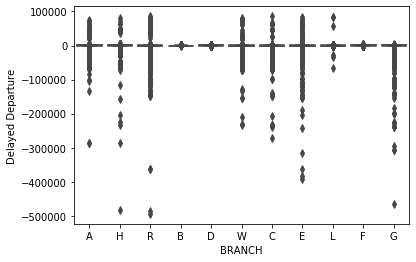

In [198]:
# Boxplot of DEPARTURE DELAYS by Branch show some possible anamolies in TIME_SCHEDULED vs. DEPARTURE timestamps
sns.boxplot(x='BRANCH',
             y='DEPARTURE_DELAY',
             data = delays)
plt.ylabel('Delayed Departure')
plt.show()

In [200]:
trains_games[['BRANCH',
              'DEPARTURE',
              'DIRECTION_NAME',
              'FREE_RUNNING',
              'STOPNAME',
              'DEPARTURE_DELAY',
              'ARRIVAL',
              'TIME_SCHEDULED',
             ]].loc[trains_games.DEPARTURE_DELAY <= -75000]

,BRANCH,DEPARTURE,DIRECTION_NAME,FREE_RUNNING,STOPNAME,DEPARTURE_DELAY,ARRIVAL,TIME_SCHEDULED
104129,E,2018-12-30 08:01:58,N-Bound,0.0,Union Station Track 11,-316652.0,2018-12-30 08:01:58,2019-01-02 23:59:30
105898,E,2018-12-31 04:33:10,S-Bound,0.0,Lincoln Station {1401},-242540.0,2019-01-02 23:56:57,2019-01-02 23:55:30
128506,A,2019-01-08 18:39:12,E-Bound,0.0,40th Ave/Airport Blvd - Gateway Park Station T...,-105168.0,2019-01-09 23:58:34,2019-01-09 23:52:00
128888,W,2019-01-07 12:41:11,E-Bound,0.0,Garrison Station,-127189.0,2019-01-07 12:40:29,2019-01-09 00:01:00
144671,C,2019-01-12 14:19:36,S-Bound,0.0,10th & Osage Station,-207594.0,2019-01-12 14:19:36,2019-01-14 23:59:30
...,...,...,...,...,...,...,...,...
1831690,G,2019-11-26 15:00:05,W-Bound,-1.0,Wheat Ridge - Ward Station Track 1,-118675.0,2019-11-27 23:59:52,2019-11-27 23:58:00
1838785,G,2019-11-28 05:17:43,E-Bound,0.0,Olde Town Arvada E-Bound,-239957.0,2019-11-28 05:16:51,2019-11-30 23:57:00
1838786,G,2019-11-28 05:21:38,E-Bound,0.0,Olde Town Arvada E-Bound,-239722.0,2019-11-28 05:21:19,2019-11-30 23:57:00
1839865,W,2019-11-28 13:21:22,W-Bound,-1.0,Sheridan Station,-211058.0,2019-11-28 13:20:57,2019-11-30 23:59:00
